In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

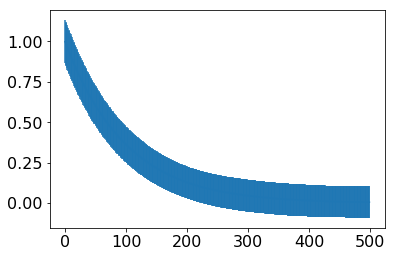

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

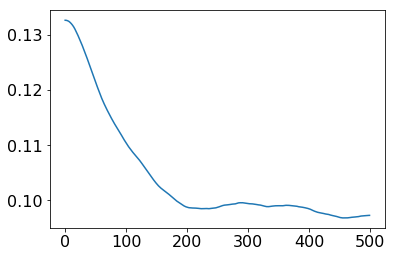

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[1,1])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[0,0])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[1,1])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[0,0])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.380
    reduced chi-square = 0.001
    Akaike info crit   = -3585.708
    Bayesian info crit = -3577.279
[[Variables]]
    amplitude:   0.80861652 +/- 0.005487 (0.68%) (init= 0.9128493)
    decay:       99.3939795 +/- 0.959985 (0.97%) (init= 92.62367)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 36.892
    reduced chi-square = 0.074
    Akaike info crit   = -1297.304
    Bayesian info crit = -1288.875
[[Variables]]
    amplitude:   0.79842634 +/- 0.006695 (0.84%) (init= 0.9128493)
    decay:       101.268806 +/- 1.056128 (1.04%) (init= 92.62367)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 0.453
    reduced chi-square = 0.001
    Akaike info crit   = -3496.930
    Bayesian info crit = -3488.501
[[Variables]]
    amplitude:   0.87052212 +/- 0.005095 (0.59%) (init= 0.6525318)
    decay:       140.464742 +/- 1.182634 (0.84%) (init= 194.1354)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 40.481
    reduced chi-square = 0.081
    Akaike info crit   = -1250.882
    Bayesian info crit = -1242.452
[[Variables]]
    amplitude:   0.85203397 +/- 0.005842 (0.69%) (init= 0.6525318)
    decay:       144.596337 +/- 1.250066 (0.86%) (init= 194.1354)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 228.241
    reduced chi-square = 0.458
    Akaike info crit   = -386.098
    Bayesian info crit = -377.669
[[Variables]]
    amplitude:   0.94382878 +/- 0.011411 (1.21%) (init= 0.9098894)
    decay:       221.886212 +/- 3.699018 (1.67%) (init= 234.8042)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.768 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.441
    reduced chi-square = 0.005
    Akaike info crit   = -2655.146
    Bayesian info crit = -2646.716
[[Variables]]
    amplitude:   1.05814237 +/- 0.016744 (1.58%) (init= 0.2744345)
    decay:       67.8925531 +/- 1.530986 (2.26%) (init= 206.5228)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 11.924
    reduced chi-square = 0.024
    Akaike info crit   = -1862.039
    Bayesian info crit = -1853.610
[[Variables]]
    amplitude:   1.43512069 +/- 0.031156 (2.17%) (init= 0.6081914)
    decay:       96.7716594 +/- 2.990336 (3.09%) (init= 266.9726)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 1206.773
    reduced chi-square = 2.423
    Akaike info crit   = 446.552
    Bayesian info crit = 454.982
[[Variables]]
    amplitude:   1.47767853 +/- 0.039899 (2.70%) (init= 0.6081914)
    decay:       93.6474565 +/- 3.148898 (3.36%) (init= 266.9726)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.872
    reduced chi-square = 0.002
    Akaike info crit   = -3169.712
    Bayesian info crit = -3161.283
[[Variables]]
    amplitude:   0.87514537 +/- 0.009203 (1.05%) (init= 0.2869067)
    decay:       80.6977411 +/- 1.208013 (1.50%) (init= 177.1385)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 87.034
    reduced chi-square = 0.175
    Akaike info crit   = -868.152
    Bayesian info crit = -859.723
[[Variables]]
    amplitude:   0.88768229 +/- 0.011724 (1.32%) (init= 0.2869067)
    decay:       78.8781287 +/- 1.306740 (1.66%) (init= 177.1385)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.390
    reduced chi-square = 0.005
    Akaike info crit   = -2665.710
    Bayesian info crit = -2657.281
[[Variables]]
    amplitude:   0.99070598 +/- 0.017053 (1.72%) (init= 0.1417597)
    decay:       63.9823376 +/- 1.569693 (2.45%) (init= 384.8919)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 237.821
    reduced chi-square = 0.478
    Akaike info crit   = -365.541
    Bayesian info crit = -357.111
[[Variables]]
    amplitude:   1.00813730 +/- 0.021992 (2.18%) (init= 0.1417597)
    decay:       61.9226021 +/- 1.721279 (2.78%) (init= 384.8919)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 87.240
    reduced chi-square = 0.175
    Akaike info crit   = -866.967
    Bayesian info crit = -858.538
[[Variables]]
    amplitude:   0.70656649 +/- 0.009289 (1.31%) (init= 0.4522161)
    decay:       123.449209 +/- 2.023681 (1.64%) (init= 207.5723)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.731 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 0.158
    reduced chi-square = 0.000
    Akaike info crit   = -4024.022
    Bayesian info crit = -4015.593
[[Variables]]
    amplitude:   0.72448833 +/- 0.003375 (0.47%) (init= 0.6792868)
    decay:       109.778625 +/- 0.728564 (0.66%) (init= 119.4738)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.260
    reduced chi-square = 0.001
    Akaike info crit   = -3774.291
    Bayesian info crit = -3765.862
[[Variables]]
    amplitude:   1.01697541 +/- 0.004386 (0.43%) (init= 1.065495)
    decay:       106.952152 +/- 0.657048 (0.61%) (init= 108.2092)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 24.486
    reduced chi-square = 0.049
    Akaike info crit   = -1502.241
    Bayesian info crit = -1493.812
[[Variables]]
    amplitude:   1.00601299 +/- 0.005257 (0.52%) (init= 1.065495)
    decay:       108.642776 +/- 0.705983 (0.65%) (init= 108.2092)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.539
    reduced chi-square = 0.001
    Akaike info crit   = -3410.447
    Bayesian info crit = -3402.018
[[Variables]]
    amplitude:   1.06891330 +/- 0.006856 (0.64%) (init= 0.8127492)
    decay:       90.1165142 +/- 0.822551 (0.91%) (init= 109.3258)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 55.403
    reduced chi-square = 0.111
    Akaike info crit   = -1093.982
    Bayesian info crit = -1085.553
[[Variables]]
    amplitude:   1.07225835 +/- 0.008735 (0.81%) (init= 0.8127492)
    decay:       89.8658851 +/- 0.913068 (1.02%) (init= 109.3258)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.530
    reduced chi-square = 0.001
    Akaike info crit   = -3419.102
    Bayesian info crit = -3410.673
[[Variables]]
    amplitude:   1.26824893 +/- 0.006871 (0.54%) (init= 0.6642048)
    decay:       88.1322588 +/- 0.679441 (0.77%) (init= 155.1132)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 52.718
    reduced chi-square = 0.106
    Akaike info crit   = -1118.818
    Bayesian info crit = -1110.389
[[Variables]]
    amplitude:   1.26563885 +/- 0.008606 (0.68%) (init= 0.6642048)
    decay:       88.1811739 +/- 0.748326 (0.85%) (init= 155.1132)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 21.167
    reduced chi-square = 0.043
    Akaike info crit   = -1575.083
    Bayesian info crit = -1566.654
[[Variables]]
    amplitude:   0.76397494 +/- 0.005230 (0.68%) (init= 0.643903)
    decay:       95.4661892 +/- 0.813723 (0.85%) (init= 106.3225)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.720 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.032
    reduced chi-square = 0.000
    Akaike info crit   = -4816.345
    Bayesian info crit = -4807.916
[[Variables]]
    amplitude:   0.81490112 +/- 0.001885 (0.23%) (init= 0.5083076)
    decay:       71.1796536 +/- 0.234516 (0.33%) (init= 97.15987)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 366.699
    reduced chi-square = 0.736
    Akaike info crit   = -149.029
    Bayesian info crit = -140.600
[[Variables]]
    amplitude:   1.24994732 +/- 0.027923 (2.23%) (init= 0.4207169)
    decay:       59.3222410 +/- 1.694192 (2.86%) (init= 157.5182)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.706 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.222
    reduced chi-square = 0.002
    Akaike info crit   = -3000.953
    Bayesian info crit = -2992.524
[[Variables]]
    amplitude:   0.86798968 +/- 0.008207 (0.95%) (init= 0.6577594)
    decay:       146.644002 +/- 2.000894 (1.36%) (init= 196.496)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.452
    reduced chi-square = 0.001
    Akaike info crit   = -3498.262
    Bayesian info crit = -3489.832
[[Variables]]
    amplitude:   0.98288913 +/- 0.005601 (0.57%) (init= 0.7153859)
    decay:       114.276826 +/- 0.928507 (0.81%) (init= 145.8703)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.706 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 43.307
    reduced chi-square = 0.087
    Akaike info crit   = -1217.137
    Bayesian info crit = -1208.708
[[Variables]]
    amplitude:   0.97096442 +/- 0.006744 (0.69%) (init= 0.7153859)
    decay:       116.471047 +/- 1.006837 (0.86%) (init= 145.8703)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 2.644
    reduced chi-square = 0.005
    Akaike info crit   = -2615.226
    Bayesian info crit = -2606.796
[[Variables]]
    amplitude:   1.06830275 +/- 0.012088 (1.13%) (init= 1.076088)
    decay:       146.132482 +/- 2.385756 (1.63%) (init= 149.9142)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.711 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 262.793
    reduced chi-square = 0.528
    Akaike info crit   = -315.616
    Bayesian info crit = -307.187
[[Variables]]
    amplitude:   1.05300503 +/- 0.014667 (1.39%) (init= 1.076088)
    decay:       149.017968 +/- 2.625383 (1.76%) (init= 149.9142)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude,

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 235.421
    reduced chi-square = 0.473
    Akaike info crit   = -370.612
    Bayesian info crit = -362.182
[[Variables]]
    amplitude:   0.58353578 +/- 0.010747 (1.84%) (init= 0.4840626)
    decay:       269.534989 +/- 7.371922 (2.74%) (init= 364.6483)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.784 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 2.639
    reduced chi-square = 0.005
    Akaike info crit   = -2616.097
    Bayesian info crit = -2607.668
[[Variables]]
    amplitude:   0.94463984 +/- 0.013368 (1.42%) (init= 0.5283069)
    decay:       117.282254 +/- 2.367639 (2.02%) (init= 241.2789)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.625
    reduced chi-square = 0.001
    Akaike info crit   = -3336.084
    Bayesian info crit = -3327.654
[[Variables]]
    amplitude:   1.07914239 +/- 0.007649 (0.71%) (init= 0.4804017)
    decay:       83.8384520 +/- 0.845763 (1.01%) (init= 117.4717)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 59.133
    reduced chi-square = 0.119
    Akaike info crit   = -1061.404
    Bayesian info crit = -1052.974
[[Variables]]
    amplitude:   1.09624393 +/- 0.009478 (0.86%) (init= 0.4804017)
    decay:       81.8415278 +/- 0.886053 (1.08%) (init= 117.4717)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 99.340
    reduced chi-square = 0.199
    Akaike info crit   = -802.025
    Bayesian info crit = -793.596
[[Variables]]
    amplitude:   0.93457207 +/- 0.015708 (1.68%) (init= 0.2503895)
    decay:       51.0310945 +/- 1.109764 (2.17%) (init= 145.4378)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 50
    # data points      = 500
    # variables        = 2
    chi-square         = 6.853
    reduced chi-square = 0.014
    Akaike info crit   = -2138.946
    Bayesian info crit = -2130.517
[[Variables]]
    amplitude:   0.95362165 +/- 0.025099 (2.63%) (init= 0.3349047)
    decay:       85.3873808 +/- 3.198844 (3.75%) (init= 361.1116)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 131.062
    reduced chi-square = 0.263
    Akaike info crit   = -663.466
    Bayesian info crit = -655.036
[[Variables]]
    amplitude:   0.95002542 +/- 0.015849 (1.67%) (init= 0.1615412)
    decay:       65.5603694 +/- 1.387707 (2.12%) (init= 299.7808)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.709 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.388
    reduced chi-square = 0.005
    Akaike info crit   = -2665.994
    Bayesian info crit = -2657.565
[[Variables]]
    amplitude:   0.92836465 +/- 0.017094 (1.84%) (init= 0.210925)
    decay:       63.6352509 +/- 1.669968 (2.62%) (init= 307.2335)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.599
    reduced chi-square = 0.003
    Akaike info crit   = -2866.533
    Bayesian info crit = -2858.103
[[Variables]]
    amplitude:   0.86076420 +/- 0.009484 (1.10%) (init= 0.6460055)
    decay:       143.360434 +/- 2.275067 (1.59%) (init= 205.3897)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.711 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 131.707
    reduced chi-square = 0.264
    Akaike info crit   = -661.009
    Bayesian info crit = -652.580
[[Variables]]
    amplitude:   0.81730044 +/- 0.010210 (1.25%) (init= 0.6460055)
    decay:       154.260421 +/- 2.447561 (1.59%) (init= 205.3897)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 392.789
    reduced chi-square = 0.789
    Akaike info crit   = -114.664
    Bayesian info crit = -106.235
[[Variables]]
    amplitude:   0.91482045 +/- 0.015888 (1.74%) (init= 0.6110752)
    decay:       193.022151 +/- 4.439700 (2.30%) (init= 340.0219)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.758 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.035
    reduced chi-square = 0.002
    Akaike info crit   = -3083.878
    Bayesian info crit = -3075.449
[[Variables]]
    amplitude:   1.01745751 +/- 0.006951 (0.68%) (init= 0.8307361)
    decay:       177.972301 +/- 1.796180 (1.01%) (init= 231.6517)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 2.267
    reduced chi-square = 0.005
    Akaike info crit   = -2692.161
    Bayesian info crit = -2683.732
[[Variables]]
    amplitude:   1.05888213 +/- 0.014122 (1.33%) (init= 0.4572278)
    decay:       89.3414577 +/- 1.695241 (1.90%) (init= 186.1728)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 222.198
    reduced chi-square = 0.446
    Akaike info crit   = -399.516
    Bayesian info crit = -391.087
[[Variables]]
    amplitude:   1.08474636 +/- 0.017842 (1.64%) (init= 0.4572278)
    decay:       86.5684141 +/- 1.777973 (2.05%) (init= 186.1728)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.614
    reduced chi-square = 0.003
    Akaike info crit   = -2861.875
    Bayesian info crit = -2853.445
[[Variables]]
    amplitude:   1.10647919 +/- 0.010636 (0.96%) (init= 0.5776732)
    decay:       113.119402 +/- 1.549964 (1.37%) (init= 214.7785)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.706 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 166.631
    reduced chi-square = 0.335
    Akaike info crit   = -543.408
    Bayesian info crit = -534.979
[[Variables]]
    amplitude:   1.10121934 +/- 0.013415 (1.22%) (init= 0.5776732)
    decay:       113.367263 +/- 1.717912 (1.52%) (init= 214.7785)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.716
    reduced chi-square = 0.003
    Akaike info crit   = -2831.343
    Bayesian info crit = -2822.914
[[Variables]]
    amplitude:   1.07509563 +/- 0.011706 (1.09%) (init= 0.596711)
    decay:       98.7142256 +/- 1.529748 (1.55%) (init= 177.1837)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 178.268
    reduced chi-square = 0.358
    Akaike info crit   = -509.656
    Bayesian info crit = -501.226
[[Variables]]
    amplitude:   1.07828302 +/- 0.014959 (1.39%) (init= 0.596711)
    decay:       98.1717607 +/- 1.694585 (1.73%) (init= 177.1837)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.651
    reduced chi-square = 0.001
    Akaike info crit   = -3315.670
    Bayesian info crit = -3307.241
[[Variables]]
    amplitude:   0.90452400 +/- 0.007352 (0.81%) (init= 0.5503236)
    decay:       94.8899403 +/- 1.097464 (1.16%) (init= 142.7812)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 67.360
    reduced chi-square = 0.135
    Akaike info crit   = -996.275
    Bayesian info crit = -987.846
[[Variables]]
    amplitude:   0.90529503 +/- 0.009368 (1.03%) (init= 0.5503236)
    decay:       94.7403778 +/- 1.220868 (1.29%) (init= 142.7812)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 1.068
    reduced chi-square = 0.002
    Akaike info crit   = -3068.336
    Bayesian info crit = -3059.907
[[Variables]]
    amplitude:   0.83664248 +/- 0.011476 (1.37%) (init= 0.1572782)
    decay:       63.1201763 +/- 1.234146 (1.96%) (init= 276.17)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 108.338
    reduced chi-square = 0.218
    Akaike info crit   = -758.673
    Bayesian info crit = -750.244
[[Variables]]
    amplitude:   0.85032043 +/- 0.014899 (1.75%) (init= 0.1572782)
    decay:       61.4844325 +/- 1.373271 (2.23%) (init= 276.17)
[[Correlations]] (unreported correlations are 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 4.374
    reduced chi-square = 0.009
    Akaike info crit   = -2363.440
    Bayesian info crit = -2355.011
[[Variables]]
    amplitude:   0.99207593 +/- 0.021807 (2.20%) (init= 0.3282846)
    decay:       71.8753585 +/- 2.249582 (3.13%) (init= 253.8474)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 442.124
    reduced chi-square = 0.888
    Akaike info crit   = -55.504
    Bayesian info crit = -47.075
[[Variables]]
    amplitude:   1.01207659 +/- 0.028142 (2.78%) (init= 0.3282846)
    decay:       69.9357106 +/- 2.457103 (3.51%) (init= 253.8474)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.183
    reduced chi-square = 0.002
    Akaike info crit   = -3017.278
    Bayesian info crit = -3008.848
[[Variables]]
    amplitude:   0.96981388 +/- 0.011259 (1.16%) (init= 0.2781858)
    decay:       72.9370258 +/- 1.205906 (1.65%) (init= 191.3199)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 114.463
    reduced chi-square = 0.230
    Akaike info crit   = -731.176
    Bayesian info crit = -722.746
[[Variables]]
    amplitude:   0.98667958 +/- 0.014222 (1.44%) (init= 0.2781858)
    decay:       70.8633190 +/- 1.289251 (1.82%) (init= 191.3199)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 49.867
    reduced chi-square = 0.100
    Akaike info crit   = -1146.619
    Bayesian info crit = -1138.189
[[Variables]]
    amplitude:   0.83142893 +/- 0.006180 (0.74%) (init= 0.7306698)
    decay:       159.577397 +/- 1.513714 (0.95%) (init= 186.7547)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.745 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 4.870
    reduced chi-square = 0.010
    Akaike info crit   = -2309.717
    Bayesian info crit = -2301.288
[[Variables]]
    amplitude:   1.21635782 +/- 0.025009 (2.06%) (init= 0.2357784)
    decay:       60.5275156 +/- 1.774274 (2.93%) (init= 363.1184)
[[Correlations]] (unreported correlation


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.703
    reduced chi-square = 0.005
    Akaike info crit   = -2604.121
    Bayesian info crit = -2595.691
[[Variables]]
    amplitude:   1.12494232 +/- 0.016468 (1.46%) (init= 0.2513636)
    decay:       78.0618971 +/- 1.626403 (2.08%) (init= 259.1756)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 274.334
    reduced chi-square = 0.551
    Akaike info crit   = -294.128
    Bayesian info crit = -285.698
[[Variables]]
    amplitude:   1.13102492 +/- 0.021076 (1.86%) (init= 0.2513636)
    decay:       77.0287744 +/- 1.802779 (2.34%) (init= 259.1756)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 186.853
    reduced chi-square = 0.375
    Akaike info crit   = -486.140
    Bayesian info crit = -477.710
[[Variables]]
    amplitude:   0.65504240 +/- 0.012835 (1.96%) (init= 0.5435711)
    decay:       138.258819 +/- 3.402004 (2.46%) (init= 174.2212)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.736 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 1.511
    reduced chi-square = 0.003
    Akaike info crit   = -2894.774
    Bayesian info crit = -2886.345
[[Variables]]
    amplitude:   0.77194879 +/- 0.008099 (1.05%) (init= 0.671549)
    decay:       194.837580 +/- 3.070232 (1.58%) (init= 234.782)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.553
    reduced chi-square = 0.003
    Akaike info crit   = -2881.301
    Bayesian info crit = -2872.872
[[Variables]]
    amplitude:   1.04238714 +/- 0.012062 (1.16%) (init= 0.3806946)
    decay:       83.7305664 +/- 1.378926 (1.65%) (init= 182.3641)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 160.257
    reduced chi-square = 0.322
    Akaike info crit   = -562.910
    Bayesian info crit = -554.481
[[Variables]]
    amplitude:   1.05434901 +/- 0.015535 (1.47%) (init= 0.3806946)
    decay:       82.5406459 +/- 1.521960 (1.84%) (init= 182.3641)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.277
    reduced chi-square = 0.001
    Akaike info crit   = -3743.919
    Bayesian info crit = -3735.490
[[Variables]]
    amplitude:   0.89504835 +/- 0.004521 (0.51%) (init= 0.669406)
    decay:       107.005324 +/- 0.769739 (0.72%) (init= 136.1449)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 26.653
    reduced chi-square = 0.054
    Akaike info crit   = -1459.847
    Bayesian info crit = -1451.418
[[Variables]]
    amplitude:   0.88342034 +/- 0.005474 (0.62%) (init= 0.669406)
    decay:       109.061301 +/- 0.840331 (0.77%) (init= 136.1449)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 83.641
    reduced chi-square = 0.168
    Akaike info crit   = -888.035
    Bayesian info crit = -879.606
[[Variables]]
    amplitude:   0.83596638 +/- 0.009419 (1.13%) (init= 0.727793)
    decay:       115.359375 +/- 1.617369 (1.40%) (init= 131.2337)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.728 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 500
    # variables        = 2
    chi-square         = 3.558
    reduced chi-square = 0.007
    Akaike info crit   = -2466.693
    Bayesian info crit = -2458.264
[[Variables]]
    amplitude:   1.51958645 +/- 0.017539 (1.15%) (init= 0.9068549)
    decay:       90.9661988 +/- 1.493821 (1.64%) (init= 109.4332)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.702
    reduced chi-square = 0.001
    Akaike info crit   = -3277.960
    Bayesian info crit = -3269.531
[[Variables]]
    amplitude:   0.90242282 +/- 0.007869 (0.87%) (init= 0.4006451)
    decay:       89.1475873 +/- 1.106093 (1.24%) (init= 196.16)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 72.048
    reduced chi-square = 0.145
    Akaike info crit   = -962.634
    Bayesian info crit = -954.205
[[Variables]]
    amplitude:   0.89170457 +/- 0.009916 (1.11%) (init= 0.4006451)
    decay:       90.6470466 +/- 1.256842 (1.39%) (init= 196.16)
[[Correlations]] (unreported correlations are <

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 2.770
    reduced chi-square = 0.006
    Akaike info crit   = -2591.816
    Bayesian info crit = -2583.387
[[Variables]]
    amplitude:   1.14750045 +/- 0.017468 (1.52%) (init= 0.4014606)
    decay:       70.9047287 +/- 1.537462 (2.17%) (init= 193.1973)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 268.957
    reduced chi-square = 0.540
    Akaike info crit   = -304.025
    Bayesian info crit = -295.596
[[Variables]]
    amplitude:   1.17629251 +/- 0.022223 (1.89%) (init= 0.4014606)
    decay:       68.3014352 +/- 1.632847 (2.39%) (init= 193.1973)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.525
    reduced chi-square = 0.001
    Akaike info crit   = -3423.648
    Bayesian info crit = -3415.218
[[Variables]]
    amplitude:   0.88848072 +/- 0.005138 (0.58%) (init= 0.7279743)
    decay:       162.760695 +/- 1.372803 (0.84%) (init= 205.5097)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.715 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 45.440
    reduced chi-square = 0.091
    Akaike info crit   = -1193.106
    Bayesian info crit = -1184.677
[[Variables]]
    amplitude:   0.86909053 +/- 0.005762 (0.66%) (init= 0.7279743)
    decay:       167.672264 +/- 1.429979 (0.85%) (init= 205.5097)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.774
    reduced chi-square = 0.002
    Akaike info crit   = -3229.118
    Bayesian info crit = -3220.689
[[Variables]]
    amplitude:   1.04652671 +/- 0.007486 (0.72%) (init= 0.7299114)
    decay:       109.379650 +/- 1.114648 (1.02%) (init= 134.0283)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 79.902
    reduced chi-square = 0.160
    Akaike info crit   = -910.898
    Bayesian info crit = -902.469
[[Variables]]
    amplitude:   1.04957066 +/- 0.009476 (0.90%) (init= 0.7299114)
    decay:       109.106008 +/- 1.224945 (1.12%) (init= 134.0283)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 3.064
    reduced chi-square = 0.006
    Akaike info crit   = -2541.480
    Bayesian info crit = -2533.051
[[Variables]]
    amplitude:   0.85893557 +/- 0.019235 (2.24%) (init= 0.1136281)
    decay:       64.4831715 +/- 2.058293 (3.19%) (init= 662.8987)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 317.187
    reduced chi-square = 0.637
    Akaike info crit   = -221.555
    Bayesian info crit = -213.126
[[Variables]]
    amplitude:   0.86316841 +/- 0.025020 (2.90%) (init= 0.1136281)
    decay:       63.7352748 +/- 2.348974 (3.69%) (init= 662.8987)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.491
    reduced chi-square = 0.003
    Akaike info crit   = -2901.669
    Bayesian info crit = -2893.240
[[Variables]]
    amplitude:   1.19753675 +/- 0.011593 (0.97%) (init= 0.585095)
    decay:       87.1341248 +/- 1.200102 (1.38%) (init= 167.3316)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 152.876
    reduced chi-square = 0.307
    Akaike info crit   = -586.487
    Bayesian info crit = -578.058
[[Variables]]
    amplitude:   1.20554440 +/- 0.014824 (1.23%) (init= 0.585095)
    decay:       86.2837906 +/- 1.325269 (1.54%) (init= 167.3316)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude,


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 111.029
    reduced chi-square = 0.223
    Akaike info crit   = -746.404
    Bayesian info crit = -737.975
[[Variables]]
    amplitude:   1.18492313 +/- 0.012617 (1.06%) (init= 0.6266634)
    decay:       86.4936873 +/- 1.150226 (1.33%) (init= 105.2593)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.717 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 2.037
    reduced chi-square = 0.004
    Akaike info crit   = -2745.557
    Bayesian info crit = -2737.127
[[Variables]]
    amplitude:   0.56106658 +/- 0.008181 (1.46%) (init= 0.4718354)
    decay:       290.469230 +/- 7.224287 (2.49%) (init= 388.4515)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.800
    reduced chi-square = 0.002
    Akaike info crit   = -3212.565
    Bayesian info crit = -3204.136
[[Variables]]
    amplitude:   0.86573013 +/- 0.005513 (0.64%) (init= 0.7683866)
    decay:       233.087690 +/- 2.334583 (1.00%) (init= 277.7965)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.736 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 59.496
    reduced chi-square = 0.119
    Akaike info crit   = -1058.346
    Bayesian info crit = -1049.916
[[Variables]]
    amplitude:   0.84202131 +/- 0.005625 (0.67%) (init= 0.7683866)
    decay:       242.186577 +/- 2.300541 (0.95%) (init= 277.7965)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 83
    # data points      = 500
    # variables        = 2
    chi-square         = 14.890
    reduced chi-square = 0.030
    Akaike info crit   = -1750.940
    Bayesian info crit = -1742.510
[[Variables]]
    amplitude:   1.16770363 +/- 0.038442 (3.29%) (init= 0.4188243)
    decay:       78.9072559 +/- 3.699376 (4.69%) (init= 397.9101)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 79
    # data points      = 500
    # variables        = 2
    chi-square         = 1501.973
    reduced chi-square = 3.016
    Akaike info crit   = 555.967
    Bayesian info crit = 564.397
[[Variables]]
    amplitude:   1.20707797 +/- 0.049742 (4.12%) (init= 0.4188243)
    decay:       75.8020574 +/- 3.924671 (5.18%) (init= 397.9101)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 50
    # data points      = 500
    # variables        = 2
    chi-square         = 1194.762
    reduced chi-square = 2.399
    Akaike info crit   = 441.551
    Bayesian info crit = 449.981
[[Variables]]
    amplitude:   1.18505949 +/- 0.043268 (3.65%) (init= 0.3649562)
    decay:       79.5050821 +/- 3.637808 (4.58%) (init= 436.5681)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.714 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.816
    reduced chi-square = 0.002
    Akaike info crit   = -3202.832
    Bayesian info crit = -3194.403
[[Variables]]
    amplitude:   0.86704713 +/- 0.005861 (0.68%) (init= 0.7261259)
    decay:       202.632178 +/- 2.075320 (1.02%) (init= 258.9535)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.175
    reduced chi-square = 0.002
    Akaike info crit   = -3020.580
    Bayesian info crit = -3012.151
[[Variables]]
    amplitude:   1.33598791 +/- 0.009400 (0.70%) (init= 1.00924)
    decay:       105.095773 +/- 1.052840 (1.00%) (init= 116.5537)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 112.784
    reduced chi-square = 0.226
    Akaike info crit   = -738.564
    Bayesian info crit = -730.135
[[Variables]]
    amplitude:   1.35801756 +/- 0.011615 (0.86%) (init= 1.00924)
    decay:       102.790478 +/- 1.093298 (1.06%) (init= 116.5537)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, d

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 443.920
    reduced chi-square = 0.891
    Akaike info crit   = -53.478
    Bayesian info crit = -45.048
[[Variables]]
    amplitude:   1.41383822 +/- 0.028711 (2.03%) (init= 0.483679)
    decay:       67.5686436 +/- 1.737653 (2.57%) (init= 183.7191)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 3.097
    reduced chi-square = 0.006
    Akaike info crit   = -2536.085
    Bayesian info crit = -2527.656
[[Variables]]
    amplitude:   1.00164946 +/- 0.019942 (1.99%) (init= 0.3052033)
    decay:       60.5208397 +/- 1.718465 (2.84%) (init= 196.0858)
[[Correlations]] (unreported correlations are

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 0.646
    reduced chi-square = 0.001
    Akaike info crit   = -3319.724
    Bayesian info crit = -3311.295
[[Variables]]
    amplitude:   1.03235372 +/- 0.009045 (0.88%) (init= 0.1879057)
    decay:       61.4131757 +/- 0.767072 (1.25%) (init= 134.2339)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 55.593
    reduced chi-square = 0.112
    Akaike info crit   = -1092.268
    Bayesian info crit = -1083.838
[[Variables]]
    amplitude:   1.05189729 +/- 0.010866 (1.03%) (init= 0.1879057)
    decay:       59.3993416 +/- 0.784059 (1.32%) (init= 134.2339)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.083
    reduced chi-square = 0.004
    Akaike info crit   = -2734.405
    Bayesian info crit = -2725.976
[[Variables]]
    amplitude:   1.20480054 +/- 0.012361 (1.03%) (init= 0.5910656)
    decay:       107.833084 +/- 1.575796 (1.46%) (init= 226.9728)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 213.570
    reduced chi-square = 0.429
    Akaike info crit   = -419.318
    Bayesian info crit = -410.889
[[Variables]]
    amplitude:   1.19378041 +/- 0.015520 (1.30%) (init= 0.5910656)
    decay:       108.736810 +/- 1.757880 (1.62%) (init= 226.9728)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.385
    reduced chi-square = 0.001
    Akaike info crit   = -3578.915
    Bayesian info crit = -3570.486
[[Variables]]
    amplitude:   1.03184544 +/- 0.006049 (0.59%) (init= 0.7048814)
    decay:       82.4520893 +/- 0.687969 (0.83%) (init= 87.58957)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 37.946
    reduced chi-square = 0.076
    Akaike info crit   = -1283.216
    Bayesian info crit = -1274.787
[[Variables]]
    amplitude:   1.04022983 +/- 0.007609 (0.73%) (init= 0.7048814)
    decay:       81.5083392 +/- 0.746644 (0.92%) (init= 87.58957)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.883
    reduced chi-square = 0.002
    Akaike info crit   = -3163.250
    Bayesian info crit = -3154.821
[[Variables]]
    amplitude:   1.00895950 +/- 0.007217 (0.72%) (init= 1.016374)
    decay:       136.055649 +/- 1.397174 (1.03%) (init= 140.6282)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.709 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 87.915
    reduced chi-square = 0.177
    Akaike info crit   = -863.114
    Bayesian info crit = -854.684
[[Variables]]
    amplitude:   0.99569403 +/- 0.008805 (0.88%) (init= 1.016374)
    decay:       138.237391 +/- 1.534914 (1.11%) (init= 140.6282)
[[Correlations]] (unreported correlations are

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.974
    reduced chi-square = 0.004
    Akaike info crit   = -2761.368
    Bayesian info crit = -2752.938
[[Variables]]
    amplitude:   1.10004988 +/- 0.013872 (1.26%) (init= 0.4680189)
    decay:       80.3775320 +/- 1.442583 (1.79%) (init= 142.2229)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 186.025
    reduced chi-square = 0.374
    Akaike info crit   = -488.360
    Bayesian info crit = -479.931
[[Variables]]
    amplitude:   1.12872602 +/- 0.017321 (1.53%) (init= 0.4680189)
    decay:       77.3170110 +/- 1.489986 (1.93%) (init= 142.2229)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 0.935
    reduced chi-square = 0.002
    Akaike info crit   = -3135.036
    Bayesian info crit = -3126.606
[[Variables]]
    amplitude:   0.89740949 +/- 0.011876 (1.32%) (init= 0.2258559)
    decay:       51.2129720 +/- 0.967680 (1.89%) (init= 165.2703)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.700 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 90.020
    reduced chi-square = 0.181
    Akaike info crit   = -851.284
    Bayesian info crit = -842.855
[[Variables]]
    amplitude:   0.91413682 +/- 0.015184 (1.66%) (init= 0.2258559)
    decay:       49.5427500 +/- 1.066950 (2.15%) (init= 165.2703)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 1.388
    reduced chi-square = 0.003
    Akaike info crit   = -2937.227
    Bayesian info crit = -2928.797
[[Variables]]
    amplitude:   1.01794957 +/- 0.011477 (1.13%) (init= 0.3696341)
    decay:       82.6714908 +/- 1.326425 (1.60%) (init= 164.6624)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 144.225
    reduced chi-square = 0.290
    Akaike info crit   = -615.614
    Bayesian info crit = -607.184
[[Variables]]
    amplitude:   1.02595269 +/- 0.014801 (1.44%) (init= 0.3696341)
    decay:       81.8694138 +/- 1.478732 (1.81%) (init= 164.6624)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.298
    reduced chi-square = 0.005
    Akaike info crit   = -2685.241
    Bayesian info crit = -2676.811
[[Variables]]
    amplitude:   0.95803874 +/- 0.014344 (1.50%) (init= 0.3722484)
    decay:       87.7420178 +/- 1.869458 (2.13%) (init= 224.0023)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 240.550
    reduced chi-square = 0.483
    Akaike info crit   = -359.836
    Bayesian info crit = -351.406
[[Variables]]
    amplitude:   0.96896009 +/- 0.018582 (1.92%) (init= 0.3722484)
    decay:       86.3954026 +/- 2.069548 (2.40%) (init= 224.0023)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 110.186
    reduced chi-square = 0.221
    Akaike info crit   = -750.215
    Bayesian info crit = -741.786
[[Variables]]
    amplitude:   1.03192583 +/- 0.014026 (1.36%) (init= 0.5895244)
    decay:       70.1667533 +/- 1.204533 (1.72%) (init= 97.91621)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.711 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 1.036
    reduced chi-square = 0.002
    Akaike info crit   = -3083.720
    Bayesian info crit = -3075.291
[[Variables]]
    amplitude:   0.97927803 +/- 0.010393 (1.06%) (init= 0.6824248)
    decay:       74.9993364 +/- 1.133422 (1.51%) (init= 98.8092)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.477
    reduced chi-square = 0.005
    Akaike info crit   = -2647.739
    Bayesian info crit = -2639.310
[[Variables]]
    amplitude:   1.22021024 +/- 0.016550 (1.36%) (init= 0.6456621)
    decay:       70.6165123 +/- 1.364456 (1.93%) (init= 116.968)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 231.788
    reduced chi-square = 0.465
    Akaike info crit   = -378.388
    Bayesian info crit = -369.959
[[Variables]]
    amplitude:   1.25337018 +/- 0.020724 (1.65%) (init= 0.6456621)
    decay:       67.7141362 +/- 1.417495 (2.09%) (init= 116.968)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 500
    # variables        = 2
    chi-square         = 0.441
    reduced chi-square = 0.001
    Akaike info crit   = -3510.574
    Bayesian info crit = -3502.144
[[Variables]]
    amplitude:   0.88433630 +/- 0.004349 (0.49%) (init= 0.9051091)
    decay:       197.799947 +/- 1.465898 (0.74%) (init= 193.9568)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.725 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 33.646
    reduced chi-square = 0.068
    Akaike info crit   = -1343.355
    Bayesian info crit = -1334.926
[[Variables]]
    amplitude:   0.87413695 +/- 0.004565 (0.52%) (init= 0.9051091)
    decay:       201.263647 +/- 1.407561 (0.70%) (init= 193.9568)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 178.624
    reduced chi-square = 0.359
    Akaike info crit   = -508.658
    Bayesian info crit = -500.229
[[Variables]]
    amplitude:   1.38108617 +/- 0.017324 (1.25%) (init= 0.3701515)
    decay:       74.3571175 +/- 1.173827 (1.58%) (init= 156.8578)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.712 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.749
    reduced chi-square = 0.004
    Akaike info crit   = -2821.712
    Bayesian info crit = -2813.283
[[Variables]]
    amplitude:   0.96548768 +/- 0.011865 (1.23%) (init= 0.570416)
    decay:       97.9476289 +/- 1.712820 (1.75%) (init= 150.8339)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 2.232
    reduced chi-square = 0.004
    Akaike info crit   = -2699.907
    Bayesian info crit = -2691.478
[[Variables]]
    amplitude:   1.00830278 +/- 0.016924 (1.68%) (init= 0.1592294)
    decay:       60.5559484 +/- 1.449438 (2.39%) (init= 326.4617)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 226.275
    reduced chi-square = 0.454
    Akaike info crit   = -390.426
    Bayesian info crit = -381.996
[[Variables]]
    amplitude:   1.02463623 +/- 0.022034 (2.15%) (init= 0.1592294)
    decay:       58.8117685 +/- 1.617570 (2.75%) (init= 326.4617)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 4.650
    reduced chi-square = 0.009
    Akaike info crit   = -2332.821
    Bayesian info crit = -2324.391
[[Variables]]
    amplitude:   1.04259821 +/- 0.022994 (2.21%) (init= 0.2500584)
    decay:       68.6211986 +/- 2.156374 (3.14%) (init= 382.1301)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 50
    # data points      = 500
    # variables        = 2
    chi-square         = 468.689
    reduced chi-square = 0.941
    Akaike info crit   = -26.330
    Bayesian info crit = -17.901
[[Variables]]
    amplitude:   1.06912984 +/- 0.029847 (2.79%) (init= 0.2500584)
    decay:       66.0994364 +/- 2.339247 (3.54%) (init= 382.1301)
[[Correlations]] (unreported correlations ar

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.691
    reduced chi-square = 0.005
    Akaike info crit   = -2606.292
    Bayesian info crit = -2597.863
[[Variables]]
    amplitude:   0.87419111 +/- 0.017314 (1.98%) (init= 0.3101067)
    decay:       70.0826146 +/- 1.977452 (2.82%) (init= 240.473)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 272.997
    reduced chi-square = 0.548
    Akaike info crit   = -296.569
    Bayesian info crit = -288.140
[[Variables]]
    amplitude:   0.88724792 +/- 0.022315 (2.52%) (init= 0.3101067)
    decay:       68.7379933 +/- 2.186743 (3.18%) (init= 240.473)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude,

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 2.095
    reduced chi-square = 0.004
    Akaike info crit   = -2731.439
    Bayesian info crit = -2723.010
[[Variables]]
    amplitude:   0.69266828 +/- 0.008526 (1.23%) (init= 0.5652503)
    decay:       266.432225 +/- 5.400325 (2.03%) (init= 371.0868)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.746 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 163.074
    reduced chi-square = 0.327
    Akaike info crit   = -554.198
    Bayesian info crit = -545.769
[[Variables]]
    amplitude:   0.65375788 +/- 0.008709 (1.33%) (init= 0.5652503)
    decay:       290.401052 +/- 5.946439 (2.05%) (init= 371.0868)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.777
    reduced chi-square = 0.004
    Akaike info crit   = -2813.961
    Bayesian info crit = -2805.531
[[Variables]]
    amplitude:   1.06045684 +/- 0.011102 (1.05%) (init= 0.5565084)
    decay:       114.319883 +/- 1.706267 (1.49%) (init= 225.1672)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.706 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 181.479
    reduced chi-square = 0.364
    Akaike info crit   = -500.731
    Bayesian info crit = -492.302
[[Variables]]
    amplitude:   1.03651917 +/- 0.013716 (1.32%) (init= 0.5565084)
    decay:       117.947228 +/- 1.943023 (1.65%) (init= 225.1672)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 2.547
    reduced chi-square = 0.005
    Akaike info crit   = -2633.801
    Bayesian info crit = -2625.372
[[Variables]]
    amplitude:   1.14411861 +/- 0.012584 (1.10%) (init= 0.9508042)
    decay:       128.454859 +/- 2.022157 (1.57%) (init= 155.1525)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.708 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 265.917
    reduced chi-square = 0.534
    Akaike info crit   = -309.708
    Bayesian info crit = -301.279
[[Variables]]
    amplitude:   1.14886893 +/- 0.015907 (1.38%) (init= 0.9508042)
    decay:       128.225595 +/- 2.217573 (1.73%) (init= 155.1525)
[[Correlations]] (unreported correlations 


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 3.386
    reduced chi-square = 0.007
    Akaike info crit   = -2491.404
    Bayesian info crit = -2482.975
[[Variables]]
    amplitude:   1.09475234 +/- 0.012826 (1.17%) (init= 0.7199959)
    decay:       169.610121 +/- 2.913674 (1.72%) (init= 287.5976)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.717 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 341.738
    reduced chi-square = 0.686
    Akaike info crit   = -184.278
    Bayesian info crit = -175.849
[[Variables]]
    amplitude:   1.05983163 +/- 0.015434 (1.46%) (init= 0.7199959)
    decay:       176.421197 +/- 3.335256 (1.89%) (init= 287.5976)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.297
    reduced chi-square = 0.005
    Akaike info crit   = -2685.577
    Bayesian info crit = -2677.147
[[Variables]]
    amplitude:   0.97763148 +/- 0.016689 (1.71%) (init= 0.2345894)
    decay:       64.2183710 +/- 1.562189 (2.43%) (init= 228.345)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 223.331
    reduced chi-square = 0.448
    Akaike info crit   = -396.973
    Bayesian info crit = -388.543
[[Variables]]
    amplitude:   1.00313679 +/- 0.021378 (2.13%) (init= 0.2345894)
    decay:       61.5708286 +/- 1.672013 (2.72%) (init= 228.345)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.568
    reduced chi-square = 0.007
    Akaike info crit   = -2465.237
    Bayesian info crit = -2456.808
[[Variables]]
    amplitude:   1.01767227 +/- 0.017789 (1.75%) (init= 0.3012944)
    decay:       88.6221101 +/- 2.203955 (2.49%) (init= 269.7765)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 373.361
    reduced chi-square = 0.750
    Akaike info crit   = -140.027
    Bayesian info crit = -131.598
[[Variables]]
    amplitude:   1.01373681 +/- 0.022807 (2.25%) (init= 0.3012944)
    decay:       88.8987931 +/- 2.494921 (2.81%) (init= 269.7765)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 3.000
    reduced chi-square = 0.006
    Akaike info crit   = -2551.987
    Bayesian info crit = -2543.558
[[Variables]]
    amplitude:   1.09139658 +/- 0.015741 (1.44%) (init= 0.5048026)
    decay:       95.3634699 +/- 1.956985 (2.05%) (init= 185.2274)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 300.066
    reduced chi-square = 0.603
    Akaike info crit   = -249.299
    Bayesian info crit = -240.870
[[Variables]]
    amplitude:   1.11656746 +/- 0.019990 (1.79%) (init= 0.5048026)
    decay:       92.7982201 +/- 2.069647 (2.23%) (init= 185.2274)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 3.527
    reduced chi-square = 0.007
    Akaike info crit   = -2471.033
    Bayesian info crit = -2462.604
[[Variables]]
    amplitude:   1.06061388 +/- 0.014532 (1.37%) (init= 0.6225643)
    decay:       133.825617 +/- 2.629407 (1.96%) (init= 261.147)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.709 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 343.881
    reduced chi-square = 0.691
    Akaike info crit   = -181.152
    Bayesian info crit = -172.723
[[Variables]]
    amplitude:   1.00823258 +/- 0.017123 (1.70%) (init= 0.6225643)
    decay:       143.010980 +/- 3.058440 (2.14%) (init= 261.147)
[[Correlations]] (unreported correlations ar

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 3.434
    reduced chi-square = 0.007
    Akaike info crit   = -2484.385
    Bayesian info crit = -2475.956
[[Variables]]
    amplitude:   1.01655316 +/- 0.020048 (1.97%) (init= 0.4533139)
    decay:       66.6191930 +/- 1.871679 (2.81%) (init= 155.0772)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 500
    # variables        = 2
    chi-square         = 334.278
    reduced chi-square = 0.671
    Akaike info crit   = -195.314
    Bayesian info crit = -186.885
[[Variables]]
    amplitude:   1.04680728 +/- 0.025701 (2.46%) (init= 0.4533139)
    decay:       63.6591417 +/- 1.987497 (3.12%) (init= 155.0772)
[[Correlations]] (unreported correlations 


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 1.949
    reduced chi-square = 0.004
    Akaike info crit   = -2767.727
    Bayesian info crit = -2759.298
[[Variables]]
    amplitude:   1.26142276 +/- 0.012996 (1.03%) (init= 0.5359023)
    decay:       90.7277401 +/- 1.330104 (1.47%) (init= 142.5542)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 193.361
    reduced chi-square = 0.388
    Akaike info crit   = -469.020
    Bayesian info crit = -460.591
[[Variables]]
    amplitude:   1.28530078 +/- 0.016450 (1.28%) (init= 0.5359023)
    decay:       88.4928528 +/- 1.413614 (1.60%) (init= 142.5542)
[[Correlations]] (unreported correlations

(0, 3)

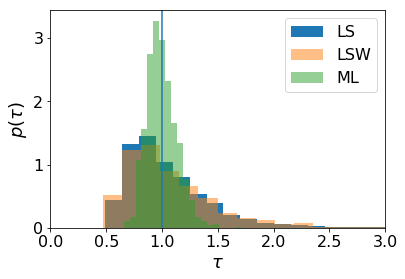

In [9]:
# decay time
plt.hist(result_array.T[0],normed=True,bins=20,label="LS")
plt.hist(result_array.T[4],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5,bins=20,label="ML")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))

In [10]:
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS std (fit):",result_array.T[1].mean())
print("Decay time LSW std (real):",result_array.T[4].std())
print("Decay time LSW std (fit):",result_array.T[5].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS std (real): 0.390589178115
Decay time LS std (fit): 0.0164793248525
Decay time LSW std (real): 0.438253657284
Decay time LSW std (fit): 0.0182667150402
Decay time Bayes std (real): 0.133071096251
Decay time Bayes std (fit): 0.141744498927


(0.25, 1.75)

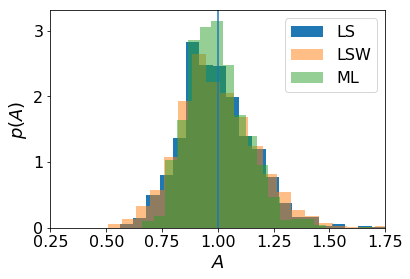

In [11]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS")
plt.hist(result_array.T[6],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.5,bins=20,label="ML")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))

In [12]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS std (fit):",result_array.T[3].mean())
print("Amplitude LSW std (real):",result_array.T[6].std())
print("Amplitude LSW std (fit):",result_array.T[7].mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.998408231979
Amplitude LS std (real): 0.161818604165
Amplitude LS std (fit): 0.0114501917652
Amplitude LSW std (real): 0.175921003812
Amplitude LSW std (fit): 0.014267716565
Amplitude Bayes mean (real): 0.997443255947
Amplitude Bayes std (real): 0.131827476656
Amplitude Bayes std (fit): 0.141053587623


(0.31829825178085258, 5.5730765117330165e-25)


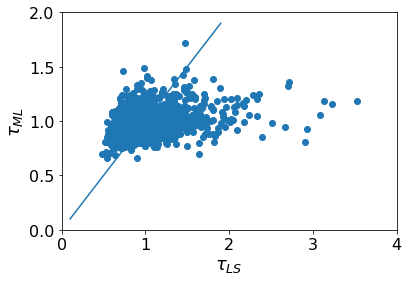

In [13]:
#decay correlation
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))

(0.83700217500302554, 1.4086478213148619e-263)


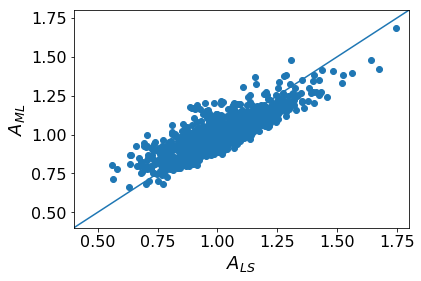

In [14]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))

In [22]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],result_array.T[3],result_array.T[0],result_array.T[1]):
    print(i,a,da,t,dt)

0 0.808616529511 0.00548767842427 0.993939795026 0.00959985065366
1 0.738387281213 0.0144286886965 1.65977251634 0.0474326337863
2 0.818995048336 0.00835205538892 1.21615558555 0.0177117035239
3 1.17742438339 0.00860617668211 0.869673357388 0.00904451718879
4 1.04378566408 0.0142180602466 0.667440109965 0.0129553622156
5 0.883051555339 0.00869744255416 0.743184172982 0.0104224907787
6 0.998668075315 0.00526645335482 0.828941709187 0.00622091316513
7 0.870560951991 0.00731449430861 1.27617222327 0.0153410558965
8 1.04694218047 0.00492104496968 1.06667168011 0.00714005217645
9 0.870522120687 0.00509564750613 1.40464742523 0.0118263411373
10 1.21032305981 0.0219405783684 0.645006662457 0.0166669988902
11 1.06783511098 0.0119170536466 1.58989858409 0.0258062188132
12 1.04663550975 0.0123725374513 1.69649226112 0.0294080334273
13 0.965294923775 0.0092236419551 1.7891184821 0.0252756011311
14 0.759784515357 0.00537206124249 1.56474640487 0.0160629227993
15 0.842851288471 0.0055647928045 1.02

156 1.07914112376 0.0195617136991 0.643266546447 0.0166172091387
157 0.849819535101 0.00662610068413 1.2786508982 0.014264309384
158 1.13538345701 0.0210553790296 0.696997082012 0.0184079236444
159 0.845372854834 0.00969603171946 0.903298746005 0.0147396445449
160 0.802108309976 0.0123216970375 1.27322509711 0.0279841395035
161 0.982889137725 0.00560149568939 1.1427682619 0.0092850797761
162 0.990285663888 0.0245790234383 0.657049061511 0.0232312427276
163 0.983835189124 0.0118401294098 0.924385167376 0.0158277835121
164 0.94454415128 0.00919568727347 1.40739143515 0.0197112258636
165 0.884562314662 0.0152718115501 0.542603627905 0.0133690381586
166 1.07756806952 0.0100770669761 0.948763190954 0.0126245322959
167 1.08504658862 0.00910842710359 1.03949257868 0.0124227143471
168 0.698768445373 0.00914619679802 1.07775829522 0.0200944611002
169 0.685869032401 0.00535765041242 1.33846529509 0.0149937225151
170 1.10727256021 0.00654451756521 1.11153957818 0.00936158139126
171 0.704480931071

419 1.03015476964 0.0200259020803 0.643602072186 0.0178275929788
420 1.07904413556 0.0138281297798 0.972428135629 0.0177369085388
421 1.0634751025 0.00906561193906 1.03092927926 0.0125091361173
422 1.40111835993 0.0146554854771 0.851368137816 0.0126729921408
423 1.07383357704 0.0449604682869 0.677031746088 0.0404084268765
424 1.00582751309 0.0236817233882 0.791910701223 0.0265442727794
425 1.16551413715 0.00537377568362 1.29291069828 0.00853396586892
426 0.947266852688 0.00626112909777 0.823119431822 0.00774236663094
427 0.960271859339 0.00737348792612 1.23998597209 0.0136074272563
428 1.06688240314 0.0234011905126 0.738490262756 0.0230602542045
429 1.13593205941 0.00938861449242 1.08026768776 0.0127177859879
430 0.915964304104 0.0130253370667 0.942743965116 0.0190744989178
431 0.953820350605 0.00833615504995 0.898902701865 0.0111779380479
432 1.20896107597 0.0155088426205 0.78503630412 0.0143327617391
433 0.901428029554 0.0147167896667 1.8131112159 0.0438520923914
434 0.987848570725 0

692 1.6417146796 0.0112893642238 0.983580989438 0.00962558859129
693 1.04308113263 0.00645223456762 1.15473569168 0.0101855692231
694 1.06391168014 0.00764091825036 0.804893065284 0.00822731778647
695 0.931358735524 0.00994369224975 0.898760745426 0.0136530502635
696 1.1396904824 0.00977321776833 1.03928619976 0.0126889085599
697 1.15531020348 0.0176082758185 0.770061454749 0.0167051942164
698 0.925058433752 0.0101182765496 0.748999785722 0.0116637880842
699 0.881898710832 0.00457509064457 1.44101926028 0.0107725775344
700 1.04279457207 0.00379295655305 1.30023607732 0.00677231374082
701 1.03184544608 0.00604929162348 0.824520893606 0.0068796972045
702 0.834411301358 0.00948706330821 0.833755825711 0.01348911978
703 1.11643281051 0.016441928842 0.67008805162 0.0140620881099
704 0.843918108948 0.00516092677772 1.25424747293 0.0109659405165
705 1.10790982917 0.00518189396971 0.965399924514 0.00642532388541
706 1.20572834813 0.0219778782501 0.953148589882 0.0247277034634
707 0.87394618276

In [72]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-1826.88544303
0.398942280401
0.00E+00
-917.935378438


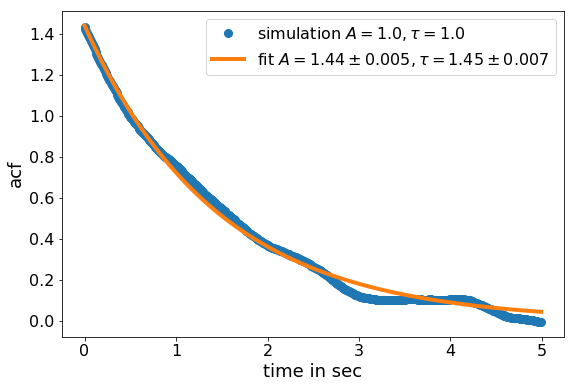

In [56]:
plt.figure(figsize=(9,6))
plt.plot(t,acf,"o",markersize=8,label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=4,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$")
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit.png",bbox_inches='tight')